# Randomized Field Arrays
Another notebook in the series of analysis of Mark's trap array design. Here I analyze aperiodic arrays and arrays with randomized phase from aperture to aperture.

In [1]:
## general imports
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift

from scipy.special import j0, j1
from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
import random as rand

## local imports
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

## Randomized Input Masks
Now use an input field created with random noise-- either in phase or periodicity

In [2]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.015
A0 = 1 # input field amplitude 

## input mask params
# r = 1/sqrt(1.66) # reflectivity of the spots. if not applicable, just set to 1. trust me.
a = 1e-4
dx = 4.3*a
dy = dx
b = f1*3.8317/(a*k)
xnum = ynum = 10

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

b=0.005031, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000101, zTalboty=0.000101


In [3]:
pts = 1000
phi_std=None #0.1
t_aper = .49
t_plate = 1
mask, x0pts, w = spot_mask(xnum, ynum, a, dx, dy, pts, phi_std=phi_std, aperture=1-t_aper, plate=t_plate)

fname =  input_amplitude_10x10_tspot49_tplate100.png


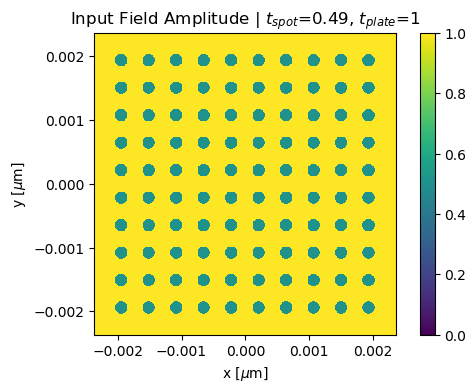

In [4]:
## plot the input field transmission

savefile=False
fname = f'input_amplitude_{xnum}x{ynum}_tspot{int(100*t_aper)}_tplate{int(100*t_plate)}.png'
print('fname = ', fname)

plt.close()
fig,ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
fig.dpi=100
ax.set_title('Input Field Amplitude | $t_{spot}$=0.49, $t_{plate}$=1',)
cax = ax.imshow(abs(mask), extent=[-w,w,-w,w])
cax.set_norm(colors.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(cax)
if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)

fname =  input_phases_10x10.png


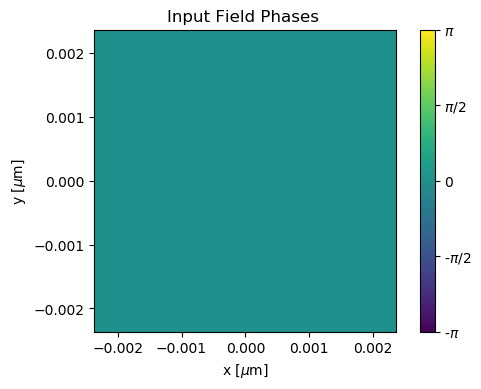

In [5]:

## plot the phases of the input mask

savefile=False
if phi_std is not None:
    fname = f'input_phases_{xnum}x{ynum}_std{int(100*phi_std)}.png'
else:
    fname = f'input_phases_{xnum}x{ynum}.png'
print('fname = ', fname)

plt.close()
fig,ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
fig.dpi = 100
scl = 1e6
title = rf'Input Field Phases '
if phi_std is not None:
    title += '$\sigma=2\pi \times {phi_std:0.2f}$'
ax.set_title(title)
cax = ax.imshow(angle(mask)/(2*pi), extent=[-w, w, -w, w])
cax.set_norm(colors.Normalize(vmin=-.5, vmax=.5))
cbar = fig.colorbar(cax, ticks=arange(-.5,.75, .25))
cbar.ax.set_yticklabels([r'-$\pi$',r'-$\pi$/2',0,r'$\pi$/2',r'$\pi$'])

if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)

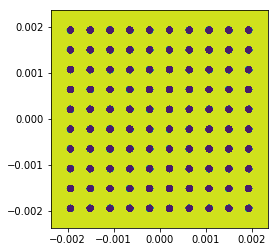

In [6]:
fig, ax = figax()
ax.contourf(x0pts, x0pts, real(mask))

In [20]:
#BIG TODO: add option to pad with ones instead! to give a broad plane wave!
# then set masked=True with b= "the radius of Mark's plate"

## compute the fourier field 

# FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
padding=200
rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
field1,x1pts = lens_xform(f1,mask,b,f1,k,x0pts,rr0,padding, masked=False)

f - z2 = 0
calculated field2 in 0.41507601737976074 s


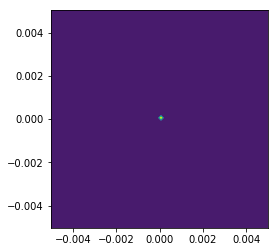

In [21]:
## plot the fourier plane intensity
x1pts = array([i*1/(x0pts[1]-x0pts[0])*lmbda*f1/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])

fig,ax = figax(roi=b)
I1_xy = conjugate(field1)*field1
I1_xy /= amax(I1_xy)
ax.contourf(x1pts,x1pts,real(I1_xy))

In [22]:
## compute the output field

# OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
padding = 200
field2,_ = lens_xform(f2,field1,b,f2,k,x1pts,rr1,padding,masked=True)

f - z2 = 0.0
calculated field2 in 0.42300844192504883 s


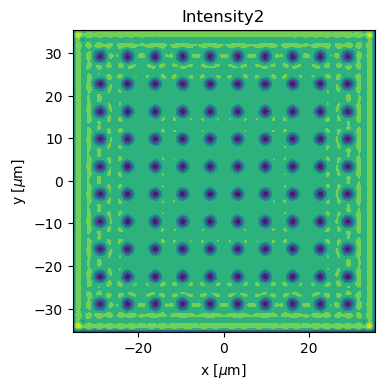

In [26]:
## plot the output intensity

I2_xy = conjugate(field2)*field2
I2_xy /= amax(I2_xy)

x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6
fig, ax = figax(xlabel=r'x [$\mu$m]', ylabel=r'y [$\mu$m]')
fig.dpi=100
cax = ax.set_title('Intensity2')

ax.contourf(x2pts*scl,x2pts*scl,I2_xy)

## program to compute output field for a range of specified parameter values

In [2]:
## physics and lens params
lmbda = 8.25e-7
k = 2*pi/lmbda
f1 = 1 # lens focal length [m]
f2 = 0.015
A0 = 1 # input field amplitude 

## input mask params
# r = 1/sqrt(1.66) # reflectivity of the spots. if not applicable, just set to 1. trust me.
a = 1e-4
dx = 4.3*a
dy = 0.7*dx
b = f1*3.8317/(a*k)
xnum = ynum = 10

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum}, ynum={ynum}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

## grid params

w = 4*b # grid half-width
pts = 2000 #1025
x = linspace(-w, w, pts)
y = linspace(-w, w, pts)
x1pts, midpt, xx, yy = get_meshgrid(w, pts)
rr = sqrt(xx**2 + yy**2)

## misc
padding = 100 # pad the field with 100 rows/cols of zeros to increase fft res

b=0.005031, a=0.0001, dx=0.00043, dy=0.000301, xnum=10, ynum=10
zTalbotx=0.000101, zTalboty=0.000049


In [50]:
## compute the output field for various values of dy using this packaged prodedure

# save contour plots as pngs?
showcontour=False # must be true in order to save file
savefile=False

# scaled real space pts for output array
x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6

lines = []
labels = []

for alpha in arange(.7,1.3,.05):

    dy = alpha*dx

    field1 = # TODO: get field from a 2D fft of a randomized input grid

    ## calculate the output intensity, normalized to intensity in focal plane
    # always run with z2 = f2 first
    for z in [0, zTalbotx]:
        z2 = f2 - z
        field2,_ = lens_xform(z2,field1,b,f2,k,x1pts,rr,padding)

        I2_xy = conjugate(field2)*field2
        if f2 - z2 == 0:
            I2xy_max = amax(I2_xy) 
#             print(f"set the I2xy_max={I2xy_max}")
        I2_xy = 1 - I2_xy/I2xy_max 
    
        fname = f'dark_I2xy_z{(f2 - z2)*1e6:0.0f}um_dydx{int(100*dy/dx)}_{xnum}x{ynum}.png'

        if showcontour:
            fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'y [$\mu$m]')
            fig.dpi = 200
            if f2 - z2 == 0:
                cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy), levels=linspace(0,1,11))
            else:
                cax = ax.contourf(x2pts*scl, x2pts*scl, real(I2_xy))
            fig.colorbar(cax, ticks=arange(0,1.2,.2))
            cax.set_norm(colors.Normalize(vmin=0, vmax=1))
            ax.set_title(rf'Intensity2 | z={(z2 - f2)*1e6:0.0f} [$\mu$m] | {xnum}x{ynum} | dy/dx={dy/dx:0.2f}')
            if savefile:
                plt.savefig(fname, bbox_inches='tight')
                print('wrote file to',fname)
                plt.close()

    lines.append(I2_xy[:,midpt+11])
    labels.append(f'dy/dx={dy/dx:0.2f}')

calculated field1 in 13.833039045333862 s
f2 - z2 = 0.0
calculated field2 in 0.7210707664489746 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7958729267120361 s
calculated field1 in 12.732946634292603 s
f2 - z2 = 0.0
calculated field2 in 0.7061119079589844 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7829060554504395 s
calculated field1 in 12.46167254447937 s
f2 - z2 = 0.0
calculated field2 in 0.6881611347198486 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7868936061859131 s
calculated field1 in 13.167784452438354 s
f2 - z2 = 0.0
calculated field2 in 0.7220687866210938 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.7978682518005371 s
calculated field1 in 12.585339069366455 s
f2 - z2 = 0.0
calculated field2 in 0.7858946323394775 s
f2 - z2 = 0.0001008545454545453
calculated field2 in 0.8078393936157227 s
calculated field1 in 12.66912031173706 s
f2 - z2 = 0.0
calculated field2 in 0.7071089744567871 s
f2 - z2 = 0.0001008545454545453
calculated f

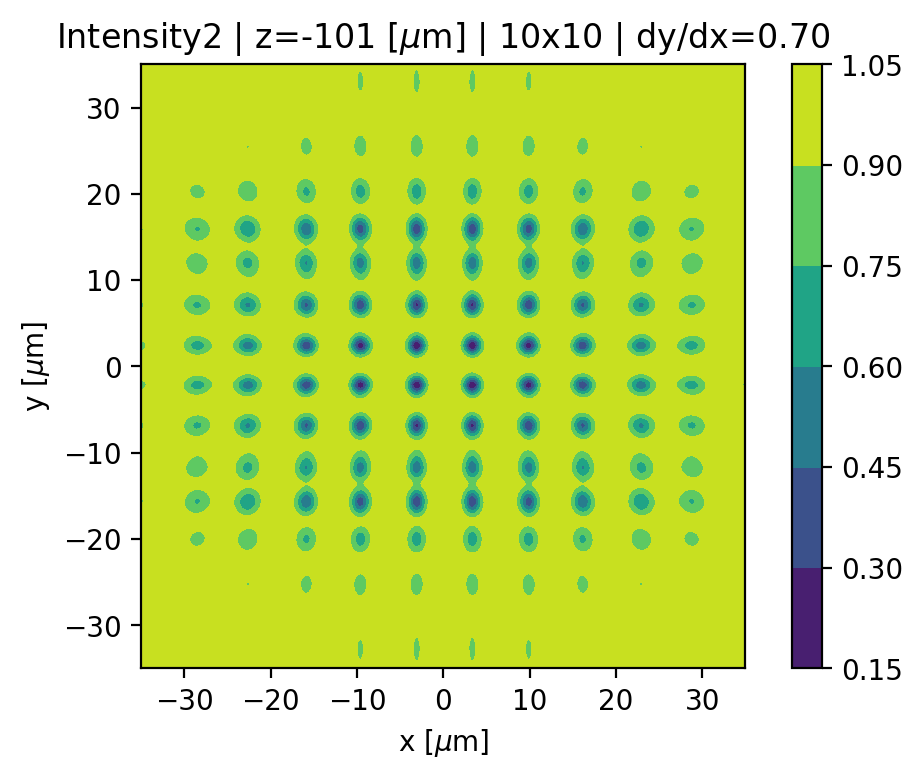

In [14]:
Image('dark_I2xy_z101um_dydx70_10x10.png')

wrote file to i2_slice_x-3.21um_z100.85um_dydx100_125.png


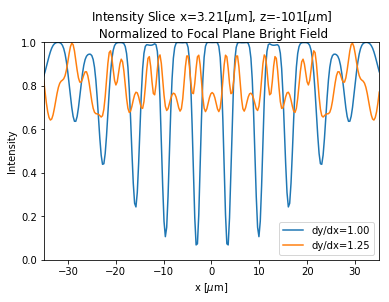

In [76]:
## plot the lines calculated above -- intensity slices in y

savefile = True
fname = f'i2_slice_x{x2pts[midpt-12]*scl:0.2f}um_z{(f2-z2)*scl:0.2f}um_dydx100_125.png'

x2pts = array([i*1/(x1pts[1]-x1pts[0])*lmbda*f2/(2*padding + pts) for i in linspace(-pts/2, pts/2, pts)])
scl = 1e6

fig,ax = figax(roi=0.000035*scl,xlabel=r'x [$\mu$m]',ylabel=r'Intensity',aspect=None)
ax.set_title(rf'Intensity Slice x={x2pts[midpt+11]*scl:0.2f}[$\mu$m], z={(z2-f2)*scl:0.0f}[$\mu$m]'+'\n Normalized to Focal Plane Bright Field')
ax.set_ylim(0,1)
# stop_idx = 7
# for line,label in zip(lines[:stop_idx],labels[:stop_idx]): 
#     ax.plot(x2pts*scl, line, label=label)
for i in [6,11]:
    ax.plot(x2pts*scl, lines[i], label=labels[i])
ax.legend(loc='lower right')

if savefile:
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)